In [2]:
import matplotlib.pyplot as plt
import networkx as nx
from torch_geometric.datasets import Planetoid

In [3]:
# torch_geometric の Dataset としてダウンロード
dataset = Planetoid(root="./dataset", name="Cora", split="full")

In [4]:
# Planetoid は torch_geometric の InMemoryDataset を継承している
# そのため、torch_geometric での学習が容易である
print(f"データセットの型 : {type(dataset)}")
print(f"ネットワークの型 : {type(dataset._data)}")

データセットの型 : <class 'torch_geometric.datasets.planetoid.Planetoid'>
ネットワークの型 : <class 'torch_geometric.data.data.Data'>


In [5]:
from collections import Counter
from torch_geometric.utils.convert import to_networkx

# PyTorch Geometric -> NetworkX への変換
cora_network = to_networkx(dataset._data, node_attrs=["y"])
print(f"ネットワークの型 : {type(cora_network)}")
print(f"ノード数 : {cora_network.number_of_nodes():,}")
print(f"エッジ数 : {cora_network.number_of_edges():,}")

ネットワークの型 : <class 'networkx.classes.digraph.DiGraph'>
ノード数 : 2,708
エッジ数 : 10,556


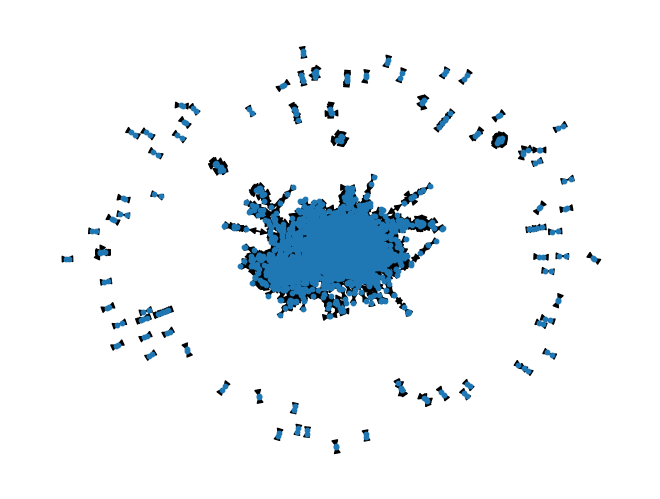

In [6]:
# Coraネットワークの描画
nx.draw(cora_network, node_size=10)

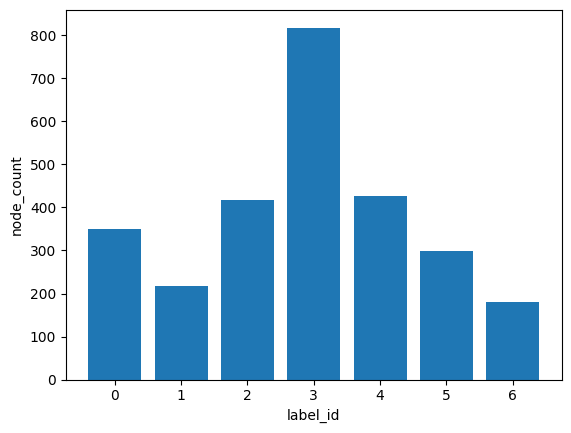

In [7]:
# 各論文の技術領域に対応するIDを取得
labels = nx.get_node_attributes(cora_network, "y")
label_counter = Counter(labels.values())

# ラベル分布を表示
plt.bar(
    [k for k, _ in sorted(label_counter.items())],
    [v for _, v in sorted(label_counter.items())],
)
plt.xlabel("label_id")
plt.ylabel("node_count")
plt.show()

In [8]:
from torch_geometric.transforms import RandomNodeSplit

# ノードを学習データとテストデータに分割
node_splitter = RandomNodeSplit(
    split="train_rest",
    num_splits=1,
    num_val=0.0,
    num_test=0.4,
    key="y",
)
splitted_data = node_splitter(dataset._data)
print(splitted_data.node_attrs())
print(splitted_data.train_mask)
print(splitted_data.test_mask)

['val_mask', 'test_mask', 'y', 'train_mask', 'x']
tensor([ True,  True,  True,  ...,  True, False, False])
tensor([False, False, False,  ..., False,  True,  True])


In [9]:
import torch
from torch_geometric.nn import Node2Vec

# node2vecモデルの定義
device = "cuda" if torch.cuda.is_available() else "cpu"
n2v_model = Node2Vec(
    splitted_data.edge_index,
    embedding_dim=64,
    walk_length=5,
    context_size=5,
    walks_per_node=10,
    num_negative_samples=1,
    p=1,
    q=1,
    sparse=False,
).to(device)

# 最適化アルゴリズムの選択
n2v_optimizer = torch.optim.Adam(
    list(n2v_model.parameters()),
    lr=0.01,
)